## Convert CBG-level housing data to a city level 
In this notebook, we merge the Census block group (CBG) level data to the census-designated places level. Data are from [Davis et al.](https://www.fhfa.gov/PolicyProgramsResearch/Research/Pages/wp1901.aspx)

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
places = gpd.read_file('../shapes/tl_2019_06_place')
places = places[places.STATEFP == '06']
places = places.to_crs(epsg=4326)
places['clean_city'] = [x.lower() for x in places.NAME]
all_places = np.unique(places.clean_city)
places.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,clean_city
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,G4110,A,6148696,0,+34.2886519,-118.4362413,"POLYGON ((-118.45601 34.28490, -118.45414 34.2...",san fernando
1,06,14190,02409487,0614190,Cloverdale,Cloverdale city,25,C1,N,N,G4110,A,8107251,0,+38.7961433,-123.0150596,"POLYGON ((-123.03512 38.78701, -123.03510 38.7...",cloverdale
2,06,16560,02410240,0616560,Cotati,Cotati city,25,C1,N,N,G4110,A,4869301,8380,+38.3284920,-122.7100491,"POLYGON ((-122.72960 38.33349, -122.72951 38.3...",cotati
3,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,G4110,A,56675175,26959120,+34.2677796,-119.2542062,"MULTIPOLYGON (((-119.29711 34.34463, -119.2970...",san buenaventura (ventura)
4,06,30014,02410601,0630014,Glendora,Glendora city,25,C1,N,N,G4110,A,50527933,400123,+34.1449643,-117.8478035,"POLYGON ((-117.89005 34.14675, -117.89005 34.1...",glendora


In [15]:
tracts = gpd.read_file('../shapes/tl_2019_06_tract')
tracts = tracts[tracts.STATEFP == '06']
tracts = tracts.to_crs(epsg=4326)
tracts['GEOID'] = tracts['GEOID'].astype(int)
# tracts['clean_city'] = [x.lower() for x in tracts.NAME]
# all_places = np.unique(places.clean_city)
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,139301,6037139301,1393.01,Census Tract 1393.01,G5020,S,2865657,0,+34.1781538,-118.5581265,"POLYGON ((-118.57150 34.17758, -118.57149 34.1..."
1,06,037,139302,6037139302,1393.02,Census Tract 1393.02,G5020,S,338289,0,+34.1767230,-118.5383655,"POLYGON ((-118.54074 34.18020, -118.54071 34.1..."
2,06,037,139502,6037139502,1395.02,Census Tract 1395.02,G5020,S,1047548,0,+34.1628402,-118.5263110,"POLYGON ((-118.53225 34.16201, -118.53177 34.1..."
3,06,037,139600,6037139600,1396,Census Tract 1396,G5020,S,2477482,0,+34.1640599,-118.5101001,"POLYGON ((-118.51859 34.15858, -118.51859 34.1..."
4,06,037,139701,6037139701,1397.01,Census Tract 1397.01,G5020,S,3396396,2411,+34.1574290,-118.4954117,"POLYGON ((-118.50980 34.15691, -118.50849 34.1..."


In [39]:
prices = pd.read_csv('../data/land_prices_tract.csv', header=1)
prices = prices[prices.State == 'California']
prices['land_value'] = prices['Land Value\n(1/4 Acre Lot, Standardized)']
prices['property_value'] = prices['Property Value (Standardized)']
in_prices = prices['Census Tract'].unique()
tracts_subset = tracts[tracts.GEOID.isin(in_prices)]
tracts_subset = tracts_subset.merge(prices, left_on='GEOID', right_on='Census Tract')
tracts_subset = pd.concat([tracts_subset, tracts_subset.bounds], axis=1)
prices.head()

,State,County,Census Tract,"Land Value\n(1/4 Acre Lot, Standardized)","Land Value\n(Per Acre, As-Is)",Land Share of Property Value,Lot Size,Interior Square Feet,Property Value (Standardized),Property Value (As-is),land_value,property_value
1750,California,Alameda County,6001400100,680200,3284200,0.447,7860,2720,1215800,1325100,680200,1215800
1751,California,Alameda County,6001400200,942200,6072100,0.551,5630,2170,1533200,1424600,942200,1533200
1752,California,Alameda County,6001400300,848400,6877800,0.545,4170,1760,1519400,1206700,848400,1519400
1753,California,Alameda County,6001400400,899300,6907500,0.577,4470,1920,1457900,1228300,899300,1457900
1754,California,Alameda County,6001400500,684300,5504800,0.567,4220,1720,1194500,939900,684300,1194500


In [78]:
overall_df = None
for i, row in places.iterrows():
    minx, miny, maxx, maxy = row.geometry.bounds
    subset = tracts_subset[(tracts_subset.minx <= maxx) & (tracts_subset.maxx >= minx) \
                           & (tracts_subset.miny <= maxy) & (tracts_subset.maxy >= miny)].copy()
    zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
    overlap = np.zeros(len(subset))
    overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
    for feature in ['land_value','property_value']:
        row[feature] = np.dot(overlap, subset[feature].values) / np.sum(overlap)
    overall_df = pd.concat([overall_df, pd.DataFrame(row).transpose()])
overall_df[['STATEFP','PLACEFP','PLACENS','GEOID', \
            'NAME','NAMELSAD','clean_city','land_value','property_value']].to_csv('../data/land_value_places.csv')

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.dis

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.dis

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].inters

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.dis

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[zero_dist_matches].intersection(row.geometry).area
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  zero_dist_matches = np.where(subset.distance(row.geometry) == 0)
/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_81586/4099965968.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  overlap[zero_dist_matches] = subset.iloc[z

KeyboardInterrupt: 

<AxesSubplot: >

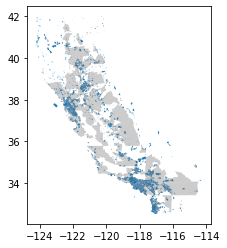

In [77]:
ax = places.plot()
tracts_subset.plot(ax=ax, color='grey',alpha=0.4)

In [80]:
overall_df.tail()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,clean_city,land_value,property_value
308,06,06000,02409837,0606000,Berkeley,Berkeley city,25,C1,Y,N,G4110,A,27127434,18715615,+37.8669717,-122.2991474,POLYGON ((-122.36778159838711 37.8667274267678...,berkeley,733004.954856,1307495.699292
309,06,20018,02410362,0620018,Dublin,Dublin city,25,C1,N,N,G4110,A,39441681,0,+37.7161507,-121.8962243,POLYGON ((-121.98779818849363 37.7093187137973...,dublin,461244.058303,881461.123129
310,06,22594,02410436,0622594,Emeryville,Emeryville city,25,C1,N,N,G4110,A,3288105,2456974,+37.8384729,-122.3016820,POLYGON ((-122.33369666509816 37.8403683652281...,emeryville,NaN,NaN
311,06,82996,02412161,0682996,Vista,Vista city,25,C1,N,N,G4110,A,48555949,0,+33.1895965,-117.2385512,POLYGON ((-117.28825277436272 33.1836435181219...,vista,176308.241335,489365.465212
312,06,50916,02411238,0650916,Newark,Newark city,25,C1,N,N,G4110,A,35936187,60526,+37.5040761,-122.0318985,POLYGON ((-122.07298152115301 37.5181584840241...,newark,443383.119884,852705.932578


In [73]:
overall_df[['STATEFP','PLACEFP','PLACENS','GEOID', 'NAME','NAMELSAD','clean_city','land_value','property_value']].to_csv('../data/land_value_places.csv')

In [68]:
thing = gpd.GeoSeries(row.geometry)
thing = thing.set_crs('EPSG:4326')
thing

0    POLYGON ((-118.45601 34.28490, -118.45414 34.2...
dtype: geometry

In [48]:
thing.crs = 'EPSG:4326'
thing.to_crs('EPSG:4326')

0    POLYGON ((-122.17389 38.18777, -122.17315 38.1...
dtype: geometry